In [2]:
import pandas as pd
import numpy as np
import os
import sys
if 'google.colab' in sys.modules:
	import tqdm.notebook as tq
else:
	import tqdm as tq
import pandas as pd

In [3]:
#@title  { form-width: "10%" }
seed = 0 #@param {type:"integer"}
class bcolors:
    HEADER = '\033[95m\033[1m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

classifier_map = {'RF' : 'RandomForestClassifier', 
                  'MLP': 'MLPClassifier', 
                  'SVM' : 'SVC', 
                  'RUS':  'RUSBoostClassifier',
                  'XGB': 'XGBClassifier',
                  'LGBM': 'LGBMClassifier'}

classifiers_args = {
  'RF' : {'random_state' : seed, 'class_weight': 'balanced'}, 
  'MLP': {'random_state' : seed}, 
  'SVM' : {'random_state' : seed, 'class_weight': 'balanced'}, 
  'RUS': {'random_state' : seed},
  'XGB': {'random_state' : seed, 'eval_metric' : 'logloss', 'scale_pos_weight' : 0.2},
  'LGBM': {'random_state' : seed, 'class_weight': 'balanced'}
}

In [10]:
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv("/Users/maurizio/BIOMAT2022/KIDNEY/dataset.csv", index_col=0)
df["label"] = df.apply(lambda row: "E + aE" if row.most_freq in ["E", "aE"] else row.most_freq, axis=1)
ylabels = df["most_freq"].values
yylabels = df["label"].values
ydistrib = Counter(ylabels)
yencoder = LabelEncoder()
y = yencoder.fit_transform(ylabels)  
yclasses_mapping = dict(zip(yencoder.classes_, yencoder.transform(yencoder.classes_)))
yrev_classes_mapping = np.array(list(yclasses_mapping.keys()))
yydistrib = Counter(yylabels)
yyencoder = LabelEncoder()
yy = yyencoder.fit_transform(yylabels)  
yyclasses_mapping = dict(zip(yyencoder.classes_, yyencoder.transform(yyencoder.classes_)))
yyrev_classes_mapping = np.array(list(yyclasses_mapping.keys()))

print(f'\tWorking on label y: {yclasses_mapping} {yrev_classes_mapping} {ydistrib}')
print(f'\tWorking on label yy: {yyclasses_mapping} {yyrev_classes_mapping} {yydistrib}')
X = df.loc[:, ~df.columns.isin(['most_freq', 'label'])].to_numpy()

	Working on label y: {'E': 0, 'aE': 1, 'aNE + NE': 2} ['E' 'aE' 'aNE + NE'] Counter({'aNE + NE': 15777, 'E': 862, 'aE': 747})
	Working on label yy: {'E + aE': 0, 'aNE + NE': 1} ['E + aE' 'aNE + NE'] Counter({'aNE + NE': 15777, 'E + aE': 1609})


In [6]:
len(y[np.where(yy == 0)])
np.unique(y)

array([0, 1, 2])

Classification with method LGBM...


5-fold: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


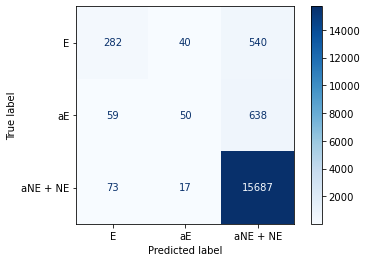

+------+-------------+-------------+---------------+---------------+-------------+-----------------------+
|      | Accuracy    | BA          | Sensitivity   | Specificity   | MCC         | CM                    |
|------+-------------+-------------+---------------+---------------+-------------+-----------------------|
| LGBM | 0.921±0.003 | 0.463±0.033 | 0.861±0.077   | 0.469±0.140   | 0.395±0.043 | [[  282    40   540]  |
|      |             |             |               |               |             |  [   59    50   638]  |
|      |             |             |               |               |             |  [   73    17 15687]] |
+------+-------------+-------------+---------------+---------------+-------------+-----------------------+


In [20]:
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tqdm import tqdm
from sklearn.metrics import *
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import RUSBoostClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from tabulate import tabulate

method = 'LGBM'
nclasses = len(yclasses_mapping)
nfolds = 5
kf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=1)
accuracies, mccs = [], []
cma = np.zeros(shape=(nclasses,nclasses), dtype=int)
cmp = np.zeros(shape=(nclasses-1,nclasses-1), dtype=int)

predictions = np.array([])
columns_names = ["Accuracy","BA", "Sensitivity", "Specificity","MCC", 'CM']
scores = pd.DataFrame(columns=columns_names)
scoresp = pd.DataFrame(columns=columns_names)
print(bcolors.HEADER +  f'Classification with method LGBM...' + bcolors.ENDC)
for fold, (train_idx, test_idx) in enumerate(tqdm(kf.split(np.arange(len(X)), y), total=kf.get_n_splits(), desc=f"{nfolds}-fold")):
    train_x, train_y, test_x, test_y, targets = X[train_idx], yy[train_idx], X[test_idx], yy[test_idx], y[test_idx]
    #print(train_idx, np.unique(train_y))
    train_idx_2 = np.where(yy[train_idx] == 0)
    test_idx_2 = np.where(yy[test_idx] == 0)
    #print(train_idx_2, test_idx_2)
    train_xx, train_yy = X[train_idx_2], y[train_idx_2]
    #mm = np.concatenate((mm, test_idx))
    #yy = np.concatenate((yy, test_y))
    clf1 = LGBMClassifier(**classifiers_args[method])
    clf1.fit(train_x, train_y)
    clf2 = LGBMClassifier(**classifiers_args[method])
    clf2.fit(train_xx, train_yy)
    
    preds = clf1.predict(test_x)
    idxs = np.where(preds == 0)
    pp = np.copy(preds)
    preds[preds>0] = 2 
    preds[idxs] = clf2.predict(test_x[idxs])
    cm = confusion_matrix(targets, preds)
    cma += cm.astype(int)
    cp = confusion_matrix(test_y, pp)
    cmp += cp.astype(int)

    scores = scores.append(pd.DataFrame([[accuracy_score(targets, preds), balanced_accuracy_score(targets, preds), 
        cm[0,0]/(cm[0,0]+cm[0,1]), cm[1,1]/(cm[1,0]+cm[1,1]), 
        matthews_corrcoef(targets, preds), cm]], columns=columns_names, index=[fold]))
    scoresp = scoresp.append(pd.DataFrame([[accuracy_score(test_y, pp), balanced_accuracy_score(test_y, pp), 
        cp[0,0]/(cp[0,0]+cm[0,1]), cp[1,1]/(cp[1,0]+cp[1,1]), 
        matthews_corrcoef(test_y, pp), cm]], columns=columns_names, index=[fold]))
dfm_scores = pd.DataFrame(scores.mean(axis=0, numeric_only=True)).T
dfs_scores = pd.DataFrame(scores.std(axis=0, numeric_only=True)).T
df_scores = pd.DataFrame([f'{row[0]:.3f}±{row[1]:.3f}' for row in pd.concat([dfm_scores,dfs_scores], axis=0).T.values.tolist()]).T
df_scores.index=[f'{method}']
df_scores['CM'] = [cma]
df_scores.columns = columns_names
disp = ConfusionMatrixDisplay(confusion_matrix=cma, display_labels=['E', 'aE', 'aNE + NE'])
disp.plot(cmap="Blues")
plt.show()
print(bcolors.OKGREEN +  tabulate(df_scores, headers='keys', tablefmt='psql') + bcolors.ENDC)

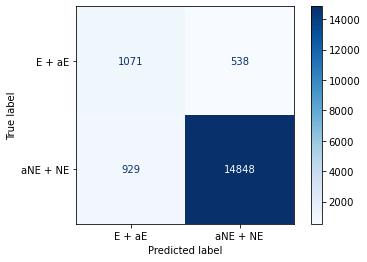

+------+-------------+-------------+---------------+---------------+-------------+-----------------+
|      | Accuracy    | BA          | Sensitivity   | Specificity   | MCC         | CM              |
|------+-------------+-------------+---------------+---------------+-------------+-----------------|
| LGBM | 0.916±0.003 | 0.803±0.009 | 0.964±0.011   | 0.941±0.004   | 0.551±0.014 | [[ 1071   538]  |
|      |             |             |               |               |             |  [  929 14848]] |
+------+-------------+-------------+---------------+---------------+-------------+-----------------+


In [22]:
dfm_scoresp = pd.DataFrame(scoresp.mean(axis=0, numeric_only=True)).T
dfs_scoresp = pd.DataFrame(scoresp.std(axis=0, numeric_only=True)).T
df_scoresp = pd.DataFrame([f'{row[0]:.3f}±{row[1]:.3f}' for row in pd.concat([dfm_scoresp,dfs_scoresp], axis=0).T.values.tolist()]).T
df_scoresp.index=[f'{method}']
df_scoresp['CM'] = [cmp]
df_scoresp.columns = columns_names
disp = ConfusionMatrixDisplay(confusion_matrix=cmp , display_labels=['E + aE', 'aNE + NE'])
disp.plot(cmap="Blues")
plt.show()
print(bcolors.OKGREEN +  tabulate(df_scoresp, headers='keys', tablefmt='psql') + bcolors.ENDC)